# Train a domain classifier on the [semantic scholar dataset](https://api.semanticscholar.org/corpus)

> Part 3: Create production inference function

![position of this step in the lifecycle](diagrams/scope-deploy.svg)
> The blue boxes show the steps implemented in this notebook.

In [Part 2](train.ipynb), we trained our AI model. Now, it's time to create **G**eneral **R**obust **E**nd-to-end **A**utomated **T**rustworthy deployment from it using the `GreatAI` Python package.

In [1]:
import re
import numpy as np
from sklearn.pipeline import Pipeline
from great_ai.utilities import clean
from great_ai import (
    MultiLabelClassificationOutput,
    ClassificationOutput,
    GreatAI,
    use_model,
    parameter,
)


@GreatAI.deploy
@use_model("small-domain-prediction", version="latest")
@parameter("target_confidence", validator=lambda c: 0 <= c <= 100)
def predict_domain(
    text: str, model: Pipeline, target_confidence: int = 50
) -> MultiLabelClassificationOutput:
    """
    Predict the scientific domain of the input text.
    Return labels until their sum likelihood is larger than `target_confidence`.
    """

    preprocessed = re.sub(r"[^a-zA-Z\s]", "", clean(text, convert_to_ascii=True))
    features = model.named_steps["vectorizer"].transform([preprocessed])
    prediction = model.named_steps["classifier"].predict_proba(features)[0]

    best_classes = sorted(enumerate(prediction), key=lambda v: v[1], reverse=True)

    results = MultiLabelClassificationOutput()
    for class_index, probability in best_classes:
        results.labels.append(
            get_label(
                model=model,
                features=features,
                class_index=class_index,
                probability=probability,
            )
        )

        if sum(r.confidence for r in results.labels) >= target_confidence:
            break

    return results


def get_label(
    model: Pipeline, features: np.ndarray, class_index: int, probability: float
) -> ClassificationOutput:
    return ClassificationOutput(
        label=model.named_steps["classifier"].classes_[class_index],
        confidence=round(probability * 100),
        explanation=[
            word
            for _, word in sorted(
                (
                    (weight, word)
                    for weight, word, count in zip(
                        model.named_steps["classifier"].feature_log_prob_[class_index],
                        model.named_steps["vectorizer"].get_feature_names_out(),
                        features.A[0],
                    )
                    if count > 0
                ),
                reverse=True,
            )
        ][:5],
    )

2022-06-24 22:38:15,518 |  WARNING | Environment variable ENVIRONMENT is not set, defaulting to development mode ‼️
2022-06-24 22:38:15,518 |     INFO | Found credentials file (/data/projects/great-ai/examples/simple/mongo.ini), initialising MongodbDriver
2022-06-24 22:38:15,519 |     INFO | Found credentials file (/data/projects/great-ai/examples/simple/mongo.ini), initialising LargeFileMongo
2022-06-24 22:38:15,520 |     INFO | Settings: configured ✅
2022-06-24 22:38:15,520 |     INFO | 🔩 tracing_database: MongodbDriver
2022-06-24 22:38:15,520 |     INFO | 🔩 large_file_implementation: LargeFileMongo
2022-06-24 22:38:15,521 |     INFO | 🔩 is_production: False
2022-06-24 22:38:15,521 |     INFO | 🔩 should_log_exception_stack: True
2022-06-24 22:38:15,521 |     INFO | 🔩 prediction_cache_size: 512
2022-06-24 22:38:15,521 |  WARNING | You still need to check whether you follow all best practices before trusting your deployment.
2022-06-24 22:38:15,522 |  WARNING | > Find out more at https

## Check accuracy on the test split

{'filter': {'$and': [{'tags': 'test'}, {'feedback': {'$ne': None}}]}, 'sort': []}


2022-06-24 22:38:16,937 |     INFO | Starting parallel map (concurrency: 12, chunk size: 154)
100%|██████████| 18441/18441 [02:53<00:00, 106.11it/s]


                       precision    recall  f1-score   support

                  Art       0.50      0.32      0.39       209
              Biology       0.76      0.83      0.79      1892
             Business       0.47      0.71      0.57       467
            Chemistry       0.82      0.68      0.74      1779
     Computer Science       0.77      0.77      0.77      1887
            Economics       0.69      0.58      0.63       393
          Engineering       0.56      0.54      0.55      1195
Environmental Science       0.47      0.59      0.53       322
            Geography       0.45      0.38      0.41       365
              Geology       0.78      0.65      0.71       350
              History       0.38      0.24      0.29       193
    Materials Science       0.75      0.78      0.77      1564
          Mathematics       0.80      0.69      0.75       767
             Medicine       0.95      0.76      0.85      4268
           Philosophy       0.53      0.10      0.17  

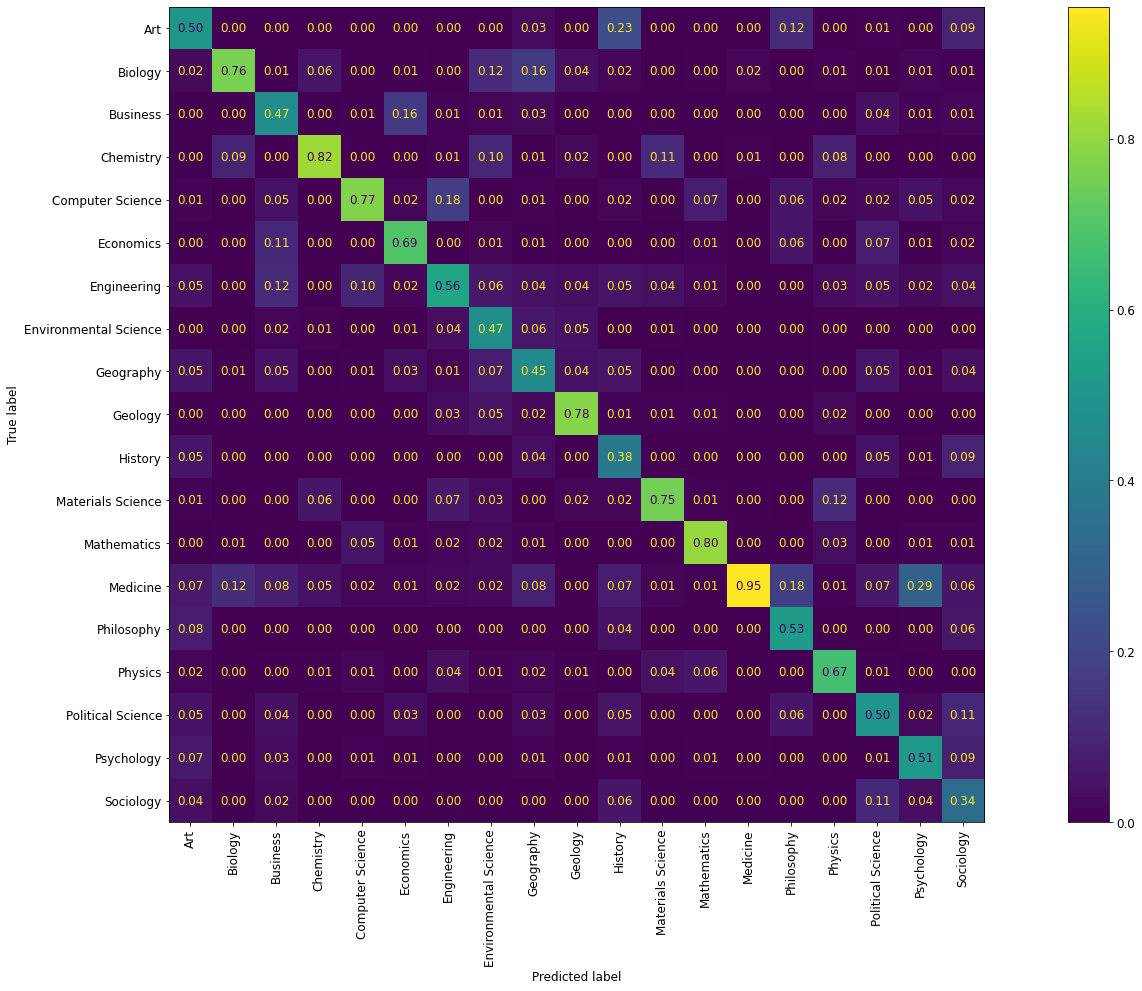

In [2]:
if __name__ == "__main__":
    from great_ai import query_ground_truth
    from sklearn import metrics

    data = query_ground_truth("test")

    X = [d.input for d in data]
    y_actual = [d.feedback for d in data]

    y_predicted = [d.output.labels[0].label for d in predict_domain.process_batch(X)]
    y_actual_aligned = [p if p in a else a[0] for p, a in zip(y_predicted, y_actual)]

    import matplotlib.pyplot as plt

    # Configure matplotlib to have nice, high-resolution charts

    %matplotlib inline

    plt.rcParams["figure.figsize"] = (30, 15)
    plt.rcParams["figure.facecolor"] = "white"
    plt.rcParams["font.size"] = 12
    plt.rcParams["axes.xmargin"] = 0

    print(metrics.classification_report(y_actual_aligned, y_predicted))
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_true=y_actual_aligned,
        y_pred=y_predicted,
        xticks_rotation="vertical",
        normalize="pred",
        values_format=".2f",
    )